# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.

Any re-use or publication of any part of the notebook is only allowed with the
written consent of the authors.

2024 (c) Mohammed Salah Al-Radhi (malradhi@tmit.bme.hu)
</PRE>

Install necessary packages:
* PyTorch Lightning: high-level deep learning library over PyTorch.
* Weights and Biases: library used for logging metrics and model checkpoints.
* Datasets: library for loading datasets from the Hugging Face Hub (https://huggingface.co/datasets).

In [1]:
!pip install -q pytorch-lightning ## modular simplification, handle checkpoints, training loop
!pip install -q wandb # experiment tracking, hyperparameter tuning
!pip install -q datasets # managing datasets for easy loading and processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Load the necessary libraries.

In [34]:
import torch # Core pytorch library to create and train neural network
import torch.nn.functional as F  # activations, loss
import torchvision # popular datasets, architectures for computer vision task
from torchvision import transforms  # augment image data
import pytorch_lightning as pl # to simplify complex setups
import torchmetrics # metrics functions like accuracy, precision compatible with pytorch lightning
import matplotlib.pyplot as plt # visualisation
import wandb # experiment tracking, logging, hyperparameters visualisation
import datasets # simplify dataset loading for computer vision task
import seaborn as sns

Login to WandB. Make sure that you have a valid WandB account. Ctrl + click on the link, copy the token from the opened page.

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Hyperparameters

In [4]:
# we will use these later for the CNN
resolution = 112 # target size for input images
num_classes = 3 # number of output classes

batch_size = 32 # No of samples per batch during training
num_workers = 2 # no of subprocesses to speed up data loading
num_epochs = 30 # No of complete passes through traning
learning_rate = 3e-4 #Step size used by optimiser
weight_decay = 1e-4 # Regularisation parameter to reduce overfitting by penalising large weights
width = 64 # No of filters in CNN layers

## Data pipeline

* We will be using the https://huggingface.co/datasets/lewtun/dog_food dataset.
* What is the difference between dataset and dataloader?
* What is the difference between image preprocessing and image augmentations? Look at the transforms. What do we use during training and validation?
* Best practices:
    * Set `num_workers > 0`. A good starting point is the number of CPU cores on your system.
    * If you use a GPU, set `pin_memory = True`. This improves the speed of CPU-to-GPU data transfer.
    * If you want to have a consistent batch_size in all iterations, set `drop_last = True`.
    * During training, set `shuffle = True`, which shuffles the order of frames in the dataset.

# TASK 1
### Implemented the following augmentations in training pipeline


1. ColorJitter to randomly change the brightness, contrast, saturation and hue
2. RandomRotation to rotate the image by a random angle
3. RandomAffine which applies random shifts to the image , say move it up by 10% of width and height
4. Gaussian blur to simulate images with different focus level
5. Random Perspective Transformation



In [24]:
# Dataset - collection of data samples (image + labels)
# Dataloader - wrapper around dataset that batches samples, shuffle them, parallel loading
# Image preprocessing - resizing, normalising pixel values, convert to tensors (Used in both training and validation)
# Image augmentation - Artificially expand the dataset ( random rotations, flips, color adjustments) (Only during training)
# num_workers > 0 -- no of cpus (to spped up data loading)
# drop last = True -- drop leftover samples after same batch size
# shuffle = True --to prevent any unintentional sequence patterns to learn from

class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):  # Encapsulate data handling, splitting and transformations during training and validation and testing
        super().__init__()
        self.train_transform = transforms.Compose([
            # set of augmentations
            # transforms.Resize(size=resolution, antialias=True),
            # transforms.CenterCrop(size=resolution),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True), # crops and resize image randomly
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # New augmentation
            transforms.RandomRotation(30),  # Random rotation
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine
            transforms.GaussianBlur(kernel_size=5),  # Gaussian blur
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None): # Load and preprocess the datasets from Huggingface hub
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self): # No shuffle and drop last
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [25]:
datamodule = DogFoodDataModule()  # Instantiate the class , setup data transformations
datamodule.prepare_data() # Prepare  required data if necessary ( not needed here)
datamodule.setup() # Setup train and validation dataset

## Visualization
* PyTorch uses channels first representation (batch, channels, height, width) vs channels last (batch, height, width, channels) by default. Keep that in mind during visualization, because matplotlib expects channels last format.

In [26]:
# In Pytorch, the default tensor is [batch, channels, height, width]
# Matplotlib format - [batch, height, width, channel]

def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"] # labels
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))  # flexile size
    for row in range(num_images): # Iterate over each image
        for column in range(num_augmentations): # For each image upto number of augmentations
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy()) # moving the channels to the last position, converting it to a NumPy array, and displaying it
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

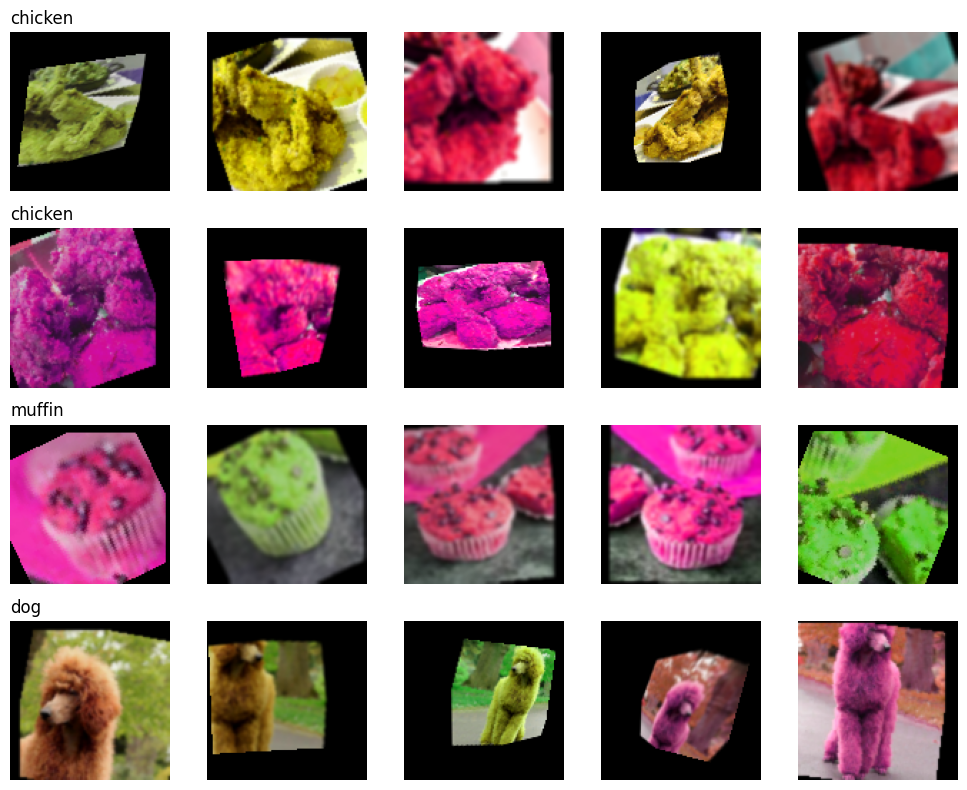

In [27]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

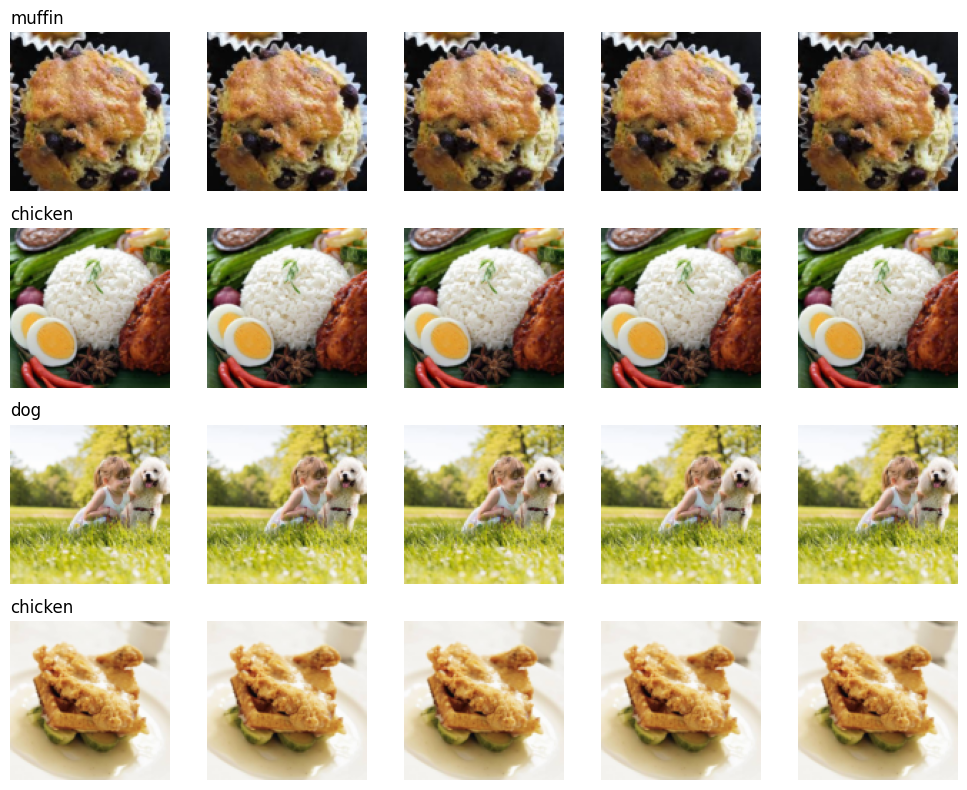

In [28]:
visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

## Classifier Model Definition
# TASK 3

In [65]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)  # setting up accuracy metric
        # Initialise confusion matrix for torch metrics
        self.confmat = torchmetrics.classification.ConfusionMatrix(num_classes=num_classes, task="multiclass")


    def forward(self, x):
        return self.model(x)  # forward pass

    def training_step(self, batch, batch_idx):  # handles a single training batch
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])  # cross entropy loss
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        # Update confusion matrix
        self.confmat.update(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        # Compute confusion matrix at the end of validation
        conf_matrix = self.confmat.compute()

        # Log confusion matrix and visualize it
        # self.log("val_confmat", conf_matrix)
        conf_matrix = conf_matrix.cpu().numpy()  # Convert to numpy array for plotting
        self.plot_confusion_matrix(conf_matrix)

        # Reset the confusion matrix for the next epoch
        self.confmat.reset()

    def plot_confusion_matrix(self, cm):
        # Function to plot the confusion matrix using Seaborn.
        plt.figure(figsize=(2,1 ))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(self.num_classes), yticklabels=range(self.num_classes))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        # Update confusion matrix
        self.confmat.update(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def on_test_epoch_end(self):
        # Compute and visualize confusion matrix at the end of test
        conf_matrix = self.confmat.compute()
        conf_matrix = conf_matrix.cpu().numpy()  # Convert to numpy array for plotting
        self.plot_confusion_matrix(conf_matrix)

        # Reset confusion matrix after test
        self.confmat.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)


## Convolutional Neural Network Definiton

* Observe our custom CNN.
* What do each of the Conv2d parameters mean?
* What are the output shapes of each layer?
* What is a fully convolutional neural network? What is their advantage?

In [49]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),  ## spatial dimensions decrease gradually

    ## Output Size=((Input Size − Kernel Size + 2 × Padding) / Stride​)+1
    # width = 64 , input size = 112 x 122
    # ((112 - 3 + 2 x 1) / 2) + 1 = floor(111/2)+1 = 56 . Therefore (batch size, 64, 56,56)
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    # ((56 - 3 + 2 x 1) / 2) + 1 = floor(55/2)+1 = 28 . Therefore (batch size, 64, 28, 28)
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    # (batch size, 64, 14, 14)
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1), # (batch_size, 64, 7, 7)
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),  # reduces the spatial dimensions (height and width) of the feature maps to 1x1, keeping the depth (number of channels) intact
    # produces a global feature map of size (batch_size, 64, 1, 1)
    torch.nn.Flatten(),  # 1D vector
    torch.nn.Linear(in_features=width, out_features=num_classes),
)
# Input size flexibilty, parameter sharing (filters applied to different regions of image), spatial hierarchies (suitable for segmentation and dense predictions)
# Lower computational complexity

# model = torchvision.models.mobilenet_v2(num_classes=num_classes)

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)


## Output Size=((Input Size − Kernel Size + 2 × Padding) / Stride​)+1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


Best practices:
* Use 16-bit floating point mixed precision for >2x faster training and 2x lower GPU memory consumption.
* If using a PyTorch 2.x on a modern GPU (Volta or Ampere architecture e.g. V100 or A100), compile your neural network.
* For better GPU utilization, use larger batch sizes.

# TASK 2
BatchNorm2D added after each ReLu  -- Modified Model

In [50]:
modified_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),  # Batch Normalization after ReLU
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

In [51]:
from torchsummary import summary


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model.to(device)
modified_model.to(device)


# Display both models
print("Original Model:")
print(model)

print("\nModified Model (with BatchNorm):")
print(modified_model)

# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Number of parameters in the original and modified model
original_params = count_parameters(model)
modified_params = count_parameters(modified_model)

print(f"\nOriginal Model Parameters: {original_params}")
print(f"Modified Model Parameters (with BatchNorm): {modified_params}")

# Usese torchsummary to display model details
print("\nOriginal Model Summary:")
summary(model, (3, resolution, resolution))

print("\nModified Model Summary:")
summary(modified_model, (3, resolution, resolution))

Original Model:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=64, out_features=3, bias=True)
)

Modified Model (with BatchNorm):
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8)

In [12]:
# model = torch.compile(model)
lit_model = ImageClassifier(model)

In [66]:
new_model = ImageClassifier(modified_model)

# TASK 3 MODEL ITERATION

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                      | Params | Mode 
---------------------------------------------------------------
0 | model    | Sequential                | 113 K  | eval 
1 | accuracy | MulticlassAccuracy        | 0      | train
2 | confmat  | MulticlassConfusionMatrix | 0      | train
---------------------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.453     Total estimated model params size (MB)
2         Modules in train mode
16        Modul

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

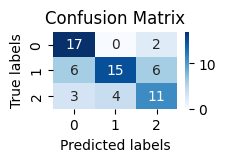

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

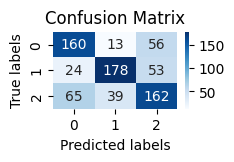

Validation: |          | 0/? [00:00<?, ?it/s]

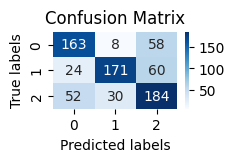

Validation: |          | 0/? [00:00<?, ?it/s]

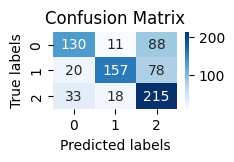

Validation: |          | 0/? [00:00<?, ?it/s]

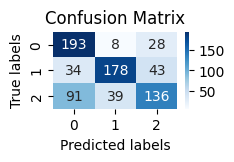

Validation: |          | 0/? [00:00<?, ?it/s]

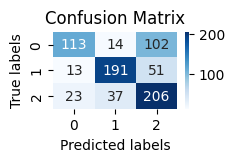

Validation: |          | 0/? [00:00<?, ?it/s]

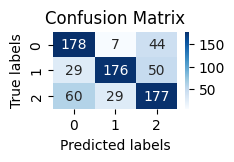

Validation: |          | 0/? [00:00<?, ?it/s]

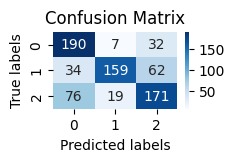

Validation: |          | 0/? [00:00<?, ?it/s]

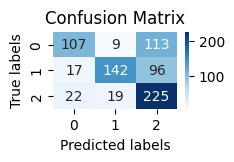

Validation: |          | 0/? [00:00<?, ?it/s]

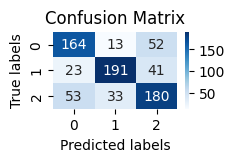

Validation: |          | 0/? [00:00<?, ?it/s]

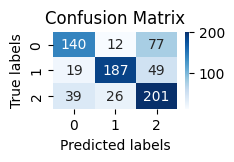

Validation: |          | 0/? [00:00<?, ?it/s]

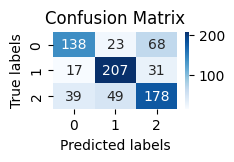

Validation: |          | 0/? [00:00<?, ?it/s]

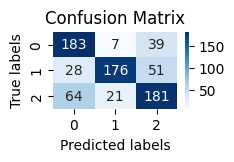

Validation: |          | 0/? [00:00<?, ?it/s]

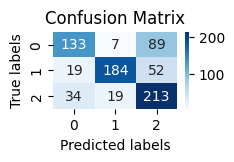

Validation: |          | 0/? [00:00<?, ?it/s]

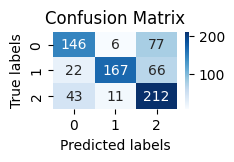

Validation: |          | 0/? [00:00<?, ?it/s]

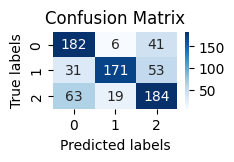

Validation: |          | 0/? [00:00<?, ?it/s]

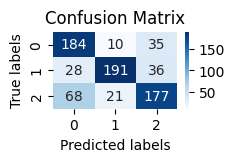

Validation: |          | 0/? [00:00<?, ?it/s]

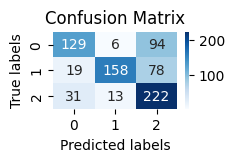

Validation: |          | 0/? [00:00<?, ?it/s]

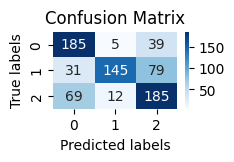

Validation: |          | 0/? [00:00<?, ?it/s]

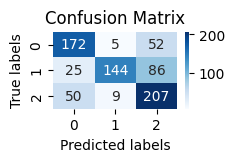

Validation: |          | 0/? [00:00<?, ?it/s]

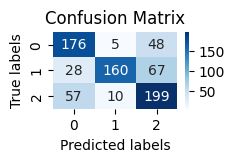

Validation: |          | 0/? [00:00<?, ?it/s]

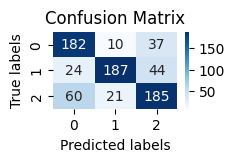

Validation: |          | 0/? [00:00<?, ?it/s]

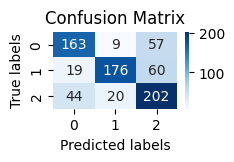

Validation: |          | 0/? [00:00<?, ?it/s]

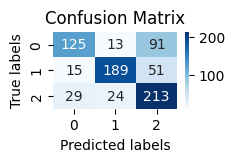

Validation: |          | 0/? [00:00<?, ?it/s]

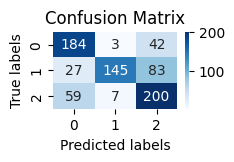

Validation: |          | 0/? [00:00<?, ?it/s]

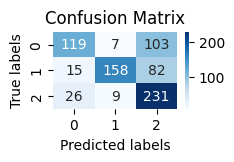

Validation: |          | 0/? [00:00<?, ?it/s]

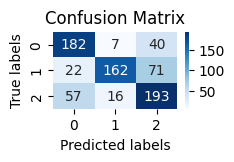

Validation: |          | 0/? [00:00<?, ?it/s]

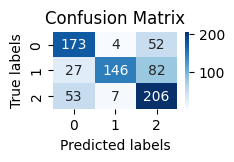

Validation: |          | 0/? [00:00<?, ?it/s]

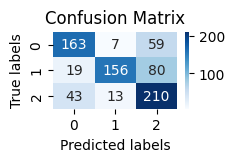

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eac3c7a2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7eac3c7a2710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: |          | 0/? [00:00<?, ?it/s]

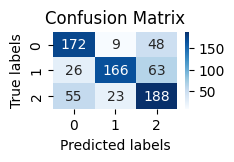

Validation: |          | 0/? [00:00<?, ?it/s]

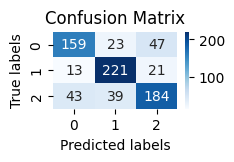

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▁▁▁▂▂▂▃▃▁▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇████
train_acc_epoch,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇█▇███████
train_acc_step,▂▄▆▁▄▆▂▄▄▆▅▅▅▅▆▄▅▇▃█▅▅▃▄▅▇▂▅▂▅█▅▅▆▆▆▅▆▅▆
train_loss_epoch,█▆▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁
train_loss_step,█▇▄▇▅▃▅▆▃▇▂▂▅▃▅▆▅▁▃▆▄▄▇▅▄▇▄▇▃█▅▆▄▁▃▃▆▄▅▁
trainer/global_step,▁▁▁▁▁▂▂▂▃▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇██
val_acc,▁▃▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▅▇▇▇▇▇▇▇█▆▆▇▇█▇▇▇▆▇▇▇█
val_loss,█▆▆▅▅▅▅▅▆▄▄▄▃▄▄▃▃▃▄▃▂▂▃▂▂▂▂▃▃▃▂▂▂▂▃▃▂▃▃▁
epoch,29
train_acc_epoch,0.66071
train_acc_step,0.6875


In [67]:
wandb_logger = pl.loggers.WandbLogger(project="dl-homework-4-vision", log_model="all")
# Logs the model architecture, weights, and other related information to WandB for every training epoch.
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
# saves the best model during training based on a validation accuracy metric.
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed", # use 16 bit floating point numbers to speed up traning and reduce memory usage
    accelerator="gpu",
    devices=1, # 1 gpu will be used
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(new_model, datamodule)
wandb.finish()

## Training
* We log our metrics using a `WandbLogger`.
* We save our best checkpoints using a `ModelCheckpoint` callback.

In [13]:
# wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
# # Logs the model architecture, weights, and other related information to WandB for every training epoch.
# checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
# # saves the best model during training based on a validation accuracy metric.
# trainer = pl.Trainer(
#     max_epochs=num_epochs,
#     precision="16-mixed", # use 16 bit floating point numbers to speed up traning and reduce memory usage
#     accelerator="gpu",
#     devices=1, # 1 gpu will be used
#     logger=wandb_logger,
#     callbacks=[checkpoint_callback],
# )
# trainer.fit(lit_model, datamodule)
# wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: dhyaneswarpraneshraj (dhyaneswarpraneshraj-bme). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 112 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.451     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇████
train_acc_epoch,▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇███████
train_acc_step,▁▃▃▄▃▄▅▄▅▅▅▅▆▄▇▆▅▅▆▇▆▇▇▆▆▆▆▆▆▅▆▆▆▆▄▆▆█▆▆
train_loss_epoch,█▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss_step,█▆▇▅▆█▅▆▄▆▄▆▄▅▂▂▃▄▃▂▃▁▂▂▃▅▂▅▃▄▂▄▂▃▅▃▂▁▂▁
trainer/global_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
val_acc,▁▂▃▃▄▃▄▅▆▅▅▆▆▅▇▇▇▇▇▇▇▆█▆▇▆██▇█
val_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▃▁▃▁▂▁▁▁▁
epoch,29
train_acc_epoch,0.76607
train_acc_step,0.75


In [ ]:
# if you stop your training early, run this line manually, to finish the wandb run
# wandb.finish()

# Tasks (during practice, solved together)
1. Visualize the augmented/preprocessed training/validation images. What do we see?
2. Turn image augmentations off in the training transforms.
3. Inspect the baseline CNN. What are the output shapes after each layer?
4. Run the baseline training.
5. Remove all ReLUs from our convolutional network. What do we expect? What do we see?
6. Replace the CNN with a MobilenetV2 network. How does it perform (train vs validation)?
7. Add regularization to the training (turn on image augmentations, add weight decay, by replacing Adam with AdamW).
8. Load ImageNet-pretrained weights into the MobileNetV2 network and finetune it.
* **Warning 1**: ImageNet has 1000 classes, we only have 3. How does this affect the final layer of the network, what can we do?
* **Warning 2**: When using pretrained weights, we need to make sure that we use the same preprocessing as during pretraining. Turn pixel value normalization on in the transforms.
9. Try finetuning only the final classification layer of the network. How does this affect performance? What can be the advantages?

# Tasks (homework)
Your tasks are the following:
1. Add some other type of image augmentation to the training pipeline. Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure.
2. Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? print it out! What is the exact number of trainable parameters in the new network? print it out!
3. Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run an evaluation, and visualize the confusion matrix.
